# Analysis of LSOA results: Added utility

In [1]:
file_name = 'lsoa_base'
limit_to_england = False

## Proportions of stroke types: Analysis of SAMueL data

Data from SAMueL using NIHSS 11+ as a surrogate for LVO:

| Admission type                       | All arrivals | Arrival within 6 hrs known onset | Arrival within 4 hrs known onset |
|--------------------------------------|--------------|----------------------------------|----------------------------------|
| Proportion all admissions            | 100          | 42.9                             | 37.1                             |
| Proportion haemorrhagic              | 11.5         | 13.6                             | 14.1                             |
| Proportion ischaemic                 | 88.5         | 86.4                             | 85.9                             |
| Proportion ischaemic with NIHSS 0-10 | 74.9         | 67.4                             | 65.7                             |
| Proportion ischaemic with NIHSS 11+  | 25.1         | 32.6                             | 34.3                             |

For original analysis see: https://samuel-book.github.io/samuel-1/descriptive_stats/10_using_nihss_10_for_lvo.html

## Import packages

In [2]:
# import contextily as ctx
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import stroke_maps.load_data
import stroke_maps.catchment
import stroke_maps.geo  # to make catchment area geometry

pd.set_option('display.max_rows', 150)

## Load data

### Load shape file

In [3]:
lsoa_gdf = stroke_maps.load_data.lsoa_geography()
lsoa_gdf = lsoa_gdf.to_crs('EPSG:27700')

lsoa_gdf.head(3)

OBJECTID   LSOA11CD             LSOA11NM            LSOA11NMW   BNG_E  \
0         1  E01000001  City of London 001A  City of London 001A  532129   
1         2  E01000002  City of London 001B  City of London 001B  532480   
2         3  E01000003  City of London 001C  City of London 001C  532245   

    BNG_N     LONG       LAT    Shape__Area  Shape__Length  \
0  181625 -0.09706  51.51810  157794.481079    1685.391778   
1  181699 -0.09197  51.51868  164882.427628    1804.828196   
2  182036 -0.09523  51.52176   42219.805717     909.223277   

                               GlobalID  \
0  b12173a3-5423-4672-a5eb-f152d2345f96   
1  90274dc4-f785-4afb-95cd-7cc1fc9a2cad   
2  7e89d0ba-f186-45fb-961c-8f5ffcd03808   

                                            geometry  
0  POLYGON ((532282.642 181906.500, 532248.262 18...  
1  POLYGON ((532746.826 181786.896, 532248.262 18...  
2  POLYGON ((532293.080 182068.426, 532419.605 18...

In [4]:
# Load country outline
# outline = geopandas.read_file('./data/Countries_(December_2022)_GB_BFC.zip')
if limit_to_england:
    # mask = outline['CTRY22NM'] == 'England'
    # outline = outline[mask]
    outline = stroke_maps.load_data.england_outline()
else:
    # mask = (outline['CTRY22NM'] == 'England') | (outline['CTRY22NM'] == 'Wales')
    # outline = outline[mask]
    outline = stroke_maps.load_data.englandwales_outline()

In [5]:
outline

country  OBJECTID   ctry11cd ctry11cdo ctry11nm ctry11nmw  \
0        0         1  E92000001       921  England    Lloegr   

                               GlobalID  \
0  27bbf7ca-99bd-4fe8-87a1-d498d48e3084   

                                            geometry  
0  MULTIPOLYGON (((83994.599 5397.099, 84001.300 ...

### Load hospital info

Load in the stroke unit coordinates and merge in the services information:

In [6]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

df_units.head(3).T

postcode                                          SY231ER  \
stroke_team              Bronglais Hospital (Aberystwyth)   
short_code                                             AB   
ssnap_name                             Bronglais Hospital   
use_ivt                                                 1   
use_mt                                                  0   
use_msu                                                 0   
transfer_unit_postcode                            nearest   
lsoa                                      Ceredigion 002A   
lsoa_code                                       W01000512   
region                  Hywel Dda University Health Board   
region_code                                     W11000025   
region_type                                           LHB   
country                                             Wales   
icb                                                   NaN   
icb_code                                              NaN   
isdn                                                  NaN   

postcode                                                           CB20QQ  \
stroke_team                             Addenbrooke's Hospital, Cambridge   
short_code                                                             AD   
ssnap_name                                         Addenbrooke's Hospital   
use_ivt                                                                 1   
use_mt                                                                  1   
use_msu                                                                 1   
transfer_unit_postcode                                            nearest   
lsoa                                                       Cambridge 013D   
lsoa_code                                                       E01017995   
region                      NHS Cambridgeshire and Peterborough ICB - 06H   
region_code                                                     E38000260   
region_type                                                         SICBL   
country                                                           England   
icb                     NHS Cambridgeshire and Peterborough Integrated...   
icb_code                                                        E54000056   
isdn                                              East of England (South)   

postcode                                                            L97AL  
stroke_team                        University Hospital Aintree, Liverpool  
short_code                                                             AI  
ssnap_name                                    University Hospital Aintree  
use_ivt                                                                 1  
use_mt                                                                  1  
use_msu                                                                 1  
transfer_unit_postcode                                            nearest  
lsoa                                                       Liverpool 005A  
lsoa_code                                                       E01006654  
region                              NHS Cheshire and Merseyside ICB - 99A  
region_code                                                     E38000101  
region_type                                                         SICBL  
country                                                           England  
icb                     NHS Cheshire and Merseyside Integrated Care Board  
icb_code                                                        E54000008  
isdn                                              Cheshire and Merseyside

In [7]:
hospitals_gdf = stroke_maps.load_data.stroke_unit_coordinates()
hospitals_gdf = pd.merge(
    hospitals_gdf, df_units[['use_ivt', 'use_mt']],
    left_index=True, right_index=True, how='right'
)

In [8]:
hospitals_gdf.head(3)

BNG_E   BNG_N   Latitude  Longitude                       geometry  \
postcode                                                                        
SY231ER   259208  281805  52.416068  -4.071578  POINT (259208.000 281805.000)   
CB20QQ    546375  254988  52.173741   0.139114  POINT (546375.000 254988.000)   
L97AL     338020  397205  53.467918  -2.935131  POINT (338020.000 397205.000)   

          use_ivt  use_mt  
postcode                   
SY231ER         1       0  
CB20QQ          1       1  
L97AL           1       1

### Load LSOA model output data

In [9]:
lsoa_data = pd.read_csv(f'./output/{file_name}.csv')
lsoa_data.head(3).T

0          1          2
lsoa                                        Adur 001A  Adur 001B  Adur 001C
closest_ivt_time                                 17.6       18.7       17.6
closest_ivt_unit                               BN25BE     BN25BE    BN112DH
closest_mt_time                                  17.6       18.7       19.8
closest_mt_unit                                BN25BE     BN25BE     BN25BE
transfer_mt_time                                  0.0        0.0       31.6
transfer_mt_unit                               BN25BE     BN25BE     BN25BE
mt_transfer_required                            False      False       True
ivt_drip_ship                                   107.6      108.7      107.6
mt_drip_ship                                    167.6      168.7      259.2
ivt_mothership                                  107.6      108.7      109.8
mt_mothership                                   167.6      168.7      169.8
drip_ship_nlvo_ivt_added_utility             0.116854   0.116409   0.116854
drip_ship_nlvo_ivt_mean_mrs                  1.636531   1.639129   1.636531
drip_ship_nlvo_ivt_mrs_less_equal_2          0.706494   0.706005   0.706494
drip_ship_nlvo_ivt_mrs_shift                -0.643469  -0.640871  -0.643469
drip_ship_nlvo_ivt_added_mrs_less_equal_2    0.126494   0.126005   0.126494
drip_ship_lvo_ivt_added_utility              0.058718   0.058412   0.058718
drip_ship_lvo_ivt_mean_mrs                   3.346549   3.348226   3.346549
drip_ship_lvo_ivt_mrs_less_equal_2           0.328789   0.328468   0.328789
drip_ship_lvo_ivt_mrs_shift                 -0.293451  -0.291774  -0.293451
drip_ship_lvo_ivt_added_mrs_less_equal_2     0.063789   0.063468   0.063789
drip_ship_lvo_mt_added_utility               0.163611   0.162952   0.109278
drip_ship_lvo_mt_mean_mrs                    2.811357   2.814939   3.101739
drip_ship_lvo_mt_mrs_less_equal_2            0.438069   0.437356   0.379811
drip_ship_lvo_mt_mrs_shift                  -0.828643  -0.825061  -0.538261
drip_ship_lvo_mt_added_mrs_less_equal_2      0.173069   0.172356   0.114811
mothership_nlvo_ivt_added_utility            0.116854   0.116409   0.115963
mothership_nlvo_ivt_mean_mrs                 1.636531   1.639129   1.641728
mothership_nlvo_ivt_mrs_less_equal_2         0.706494   0.706005   0.705514
mothership_nlvo_ivt_mrs_shift               -0.643469  -0.640871  -0.638272
mothership_nlvo_ivt_added_mrs_less_equal_2   0.126494   0.126005   0.125514
mothership_lvo_ivt_added_utility             0.058718   0.058412   0.058107
mothership_lvo_ivt_mean_mrs                  3.346549   3.348226   3.349902
mothership_lvo_ivt_mrs_less_equal_2          0.328789   0.328468   0.328146
mothership_lvo_ivt_mrs_shift                -0.293451  -0.291774  -0.290098
mothership_lvo_ivt_added_mrs_less_equal_2    0.063789   0.063468   0.063146
mothership_lvo_mt_added_utility              0.163611   0.162952   0.162292
mothership_lvo_mt_mean_mrs                   2.811357   2.814939   2.818519
mothership_lvo_mt_mrs_less_equal_2           0.438069   0.437356   0.436643
mothership_lvo_mt_mrs_shift                 -0.828643  -0.825061  -0.821481
mothership_lvo_mt_added_mrs_less_equal_2     0.173069   0.172356   0.171643
weighted_drip_ship_added_utility              0.03479   0.034647   0.029357
weighted_drip_ship_mrs_less_equal_2          0.153001   0.152846   0.147175
weighted_drip_ship_mean_mrs                  0.753793   0.754593   0.782832
weighted_drip_ship_mrs_shift                -0.181807  -0.181007  -0.152768
weighted_drip_ship_added_mrs_less_equal_2    0.037276   0.037121    0.03145
weighted_mothership_added_utility             0.03479   0.034647   0.034504
weighted_mothership_mrs_less_equal_2         0.153001   0.152846   0.152691
weighted_mothership_mean_mrs                 0.753793   0.754593   0.755392
weighted_mothership_mrs_shift               -0.181807  -0.181007  -0.180208
weighted_mothership_added_mrs_less_equal_2   0.037276   0.037121   0.036966

In [10]:
# Merge with shape file

lsoa_data_gdf = lsoa_gdf.merge(lsoa_data, left_on='LSOA11NM', right_on='lsoa', how='right')
lsoa_data_gdf.head()

OBJECTID   LSOA11CD   LSOA11NM  LSOA11NMW     BNG_E     BNG_N     LONG  \
0   30557.0  E01031349  Adur 001A  Adur 001A  524915.0  105607.0 -0.22737   
1   30558.0  E01031350  Adur 001B  Adur 001B  524825.0  106265.0 -0.22842   
2   30559.0  E01031351  Adur 001C  Adur 001C  523053.0  108004.0 -0.25300   
3   30560.0  E01031352  Adur 001D  Adur 001D  524141.0  106299.0 -0.23812   
4   30578.0  E01031370  Adur 001E  Adur 001E  523561.0  105916.0 -0.24649   

        LAT   Shape__Area  Shape__Length  ...  \
0  50.83651  3.641032e+05    3054.751704  ...   
1  50.84244  2.921732e+05    2977.102897  ...   
2  50.85845  5.281768e+06   11671.349143  ...   
3  50.84290  2.452292e+05    2134.908586  ...   
4  50.83958  2.402445e+05    2447.096939  ...   

  weighted_drip_ship_added_utility weighted_drip_ship_mrs_less_equal_2  \
0                         0.034790                            0.153001   
1                         0.034647                            0.152846   
2                         0.029357                            0.147175   
3                         0.029357                            0.147175   
4                         0.029499                            0.147327   

  weighted_drip_ship_mean_mrs  weighted_drip_ship_mrs_shift  \
0                    0.753793                     -0.181807   
1                    0.754593                     -0.181007   
2                    0.782832                     -0.152768   
3                    0.782832                     -0.152768   
4                    0.782052                     -0.153548   

  weighted_drip_ship_added_mrs_less_equal_2  \
0                                  0.037276   
1                                  0.037121   
2                                  0.031450   
3                                  0.031450   
4                                  0.031602   

   weighted_mothership_added_utility weighted_mothership_mrs_less_equal_2  \
0                           0.034790                             0.153001   
1                           0.034647                             0.152846   
2                           0.034504                             0.152691   
3                           0.034504                             0.152691   
4                           0.034504                             0.152691   

   weighted_mothership_mean_mrs weighted_mothership_mrs_shift  \
0                      0.753793                     -0.181807   
1                      0.754593                     -0.181007   
2                      0.755392                     -0.180208   
3                      0.755392                     -0.180208   
4                      0.755392                     -0.180208   

   weighted_mothership_added_mrs_less_equal_2  
0                                    0.037276  
1                                    0.037121  
2                                    0.036966  
3                                    0.036966  
4                                    0.036966  

[5 rows x 64 columns]

## Calculate difference between Mothership and Drip and Ship

In [15]:
cohort_names = ['nlvo_ivt', 'lvo_ivt', 'lvo_mt']

outcome_names = ['added_utility', 'added_mrs_less_equal_2', 'mrs_shift']

In [22]:
cols_diff = [f'{c}_{o}_mothership_minus_dripship' for c in cohort_names for o in outcome_names]
cols_moth = [f'mothership_{c}_{o}' for c in cohort_names for o in outcome_names]
cols_drip = [f'drip_ship_{c}_{o}' for c in cohort_names for o in outcome_names]

lsoa_data_gdf[cols_diff] = lsoa_data_gdf[cols_moth].values - lsoa_data_gdf[cols_drip].values

## Plots

In [34]:
def plot_six(
        data_field,
        data_name,
        lsoa_data_gdf,
        hospitals_gdf,
        outline,
        reverse_cmaps=False
    ):
    fig = plt.figure(figsize=(18,12))
    
    ################### Plot data values ###################
    
    cols = [
        f'drip_ship_nlvo_ivt_{data_field}',
        f'mothership_nlvo_ivt_{data_field}',
        f'drip_ship_lvo_mt_{data_field}',
        f'mothership_lvo_mt_{data_field}'
    ]
    
    titles = [
        f'Drip and ship nLVO {data_name}',
        f'Mothership nLVO {data_name}',
        f'Drip and ship LVO {data_name}',    
        f'Mothership LVO {data_name}'
    ]

    cmap = 'inferno'
    cmap_diff = 'bwr_r'
    if reverse_cmaps:
        cmap += '_r'
        cmap_diff += '_r'
        cmap = cmap.split('_r_r')[0]
        cmap_diff = cmap_diff.split('_r_r')[0]
    
    # Indexes for subplots (to leave gaps on right for diff between Mothership and Drip and Ship)
    indexes = [1, 2, 4, 5]
    
    # Find maximum of data
    vmin = np.min([lsoa_data_gdf[col].min() for col in cols])
    vmax = np.max([lsoa_data_gdf[col].max() for col in cols])
    
    for i in range(4):
        ax = fig.add_subplot(2, 3, indexes[i])
    
        # Plot data
        lsoa_data_gdf.plot(ax=ax, # Set which axes to use for plot (only one here)
                     column=cols[i], # Column to apply colour
                     antialiased=False, # Avoids artifact boundry lines
                     edgecolor='face', # Make LSOA boundry same colour as area
                     vmin=vmin, # Manual scale min (remove to make automatic)
                     vmax=vmax, # Manual scale max (remove to make automatic)
                     cmap=cmap, # Colour map to use
                     # Adjust size of colourmap key, and add label
                     legend_kwds={'shrink':0.5, 'label':f'{data_name}'},
                     # Set to display legend
                     legend=True)
        
        # Add country boarder
        outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
        
        # Add hospitals
        mask = hospitals_gdf['use_ivt'] == 1
        hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
        mask = hospitals_gdf['use_mt'] == 1
        hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')
    
        # Tighten map around mainland England and Wales
        ax.set_xlim(120000)
    
        ax.set_title(titles[i])
        ax.set_axis_off() # Turn of axis line and numbers
    
    ################### Plot differences between mothership and drip and ship ###################
    
    cols = [
        f'nlvo_ivt_{data_field}_mothership_minus_dripship',
        f'lvo_mt_{data_field}_mothership_minus_dripship'
    ]
    
    # Find absolute maximum of data extent
    vmax = np.max((np.abs([lsoa_data_gdf[col].min() for col in cols]), 
                   np.abs([lsoa_data_gdf[col].max() for col in cols])))
    vmin = -vmax
    
    titles = [f'nLVO advantage of Mothership ({data_name})',
              f'LVO advantage of Mothership ({data_name})']
    
    # Indexes for subplots
    indexes = [3, 6]
    
    for i in range(2):
        ax = fig.add_subplot(2, 3, indexes[i])
    
        lsoa_data_gdf.plot(ax=ax, # Set which axes to use for plot (only one here)
                     column=cols[i], # Column to apply colour
                     antialiased=False, # Avoids artifact boundry lines
                     edgecolor='face', # Make LSOA boundry same colour as area
                     vmin=vmin, # Manual scale min (remove to make automatic)
                     vmax=vmax, # Manual scale max (remove to make automatic)
                     cmap=cmap_diff, # Colour map to use
                     # Adjust size of colourmap key, and add label
                     legend_kwds={'shrink':0.5, 'label':f'Advantage of Mothership ({data_name})'},
                     # Set to display legend
                     legend=True)
    
        # Add country boarder
        outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
        
        # Add hospitals
        mask = hospitals_gdf['use_ivt'] == 1
        hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
        mask = hospitals_gdf['use_mt'] == 1
        hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')
    
        ax.set_title(titles[i])
        ax.set_axis_off() # Turn of axis line and numbers    
    
        # Tighten map around mainland England and Wales
        ax.set_xlim(120000)
        
    plt.tight_layout(pad=1)
    plt.savefig(f'./output/{data_field}_six_in_one.jpg', dpi=300, bbox_inches='tight')
    plt.show()

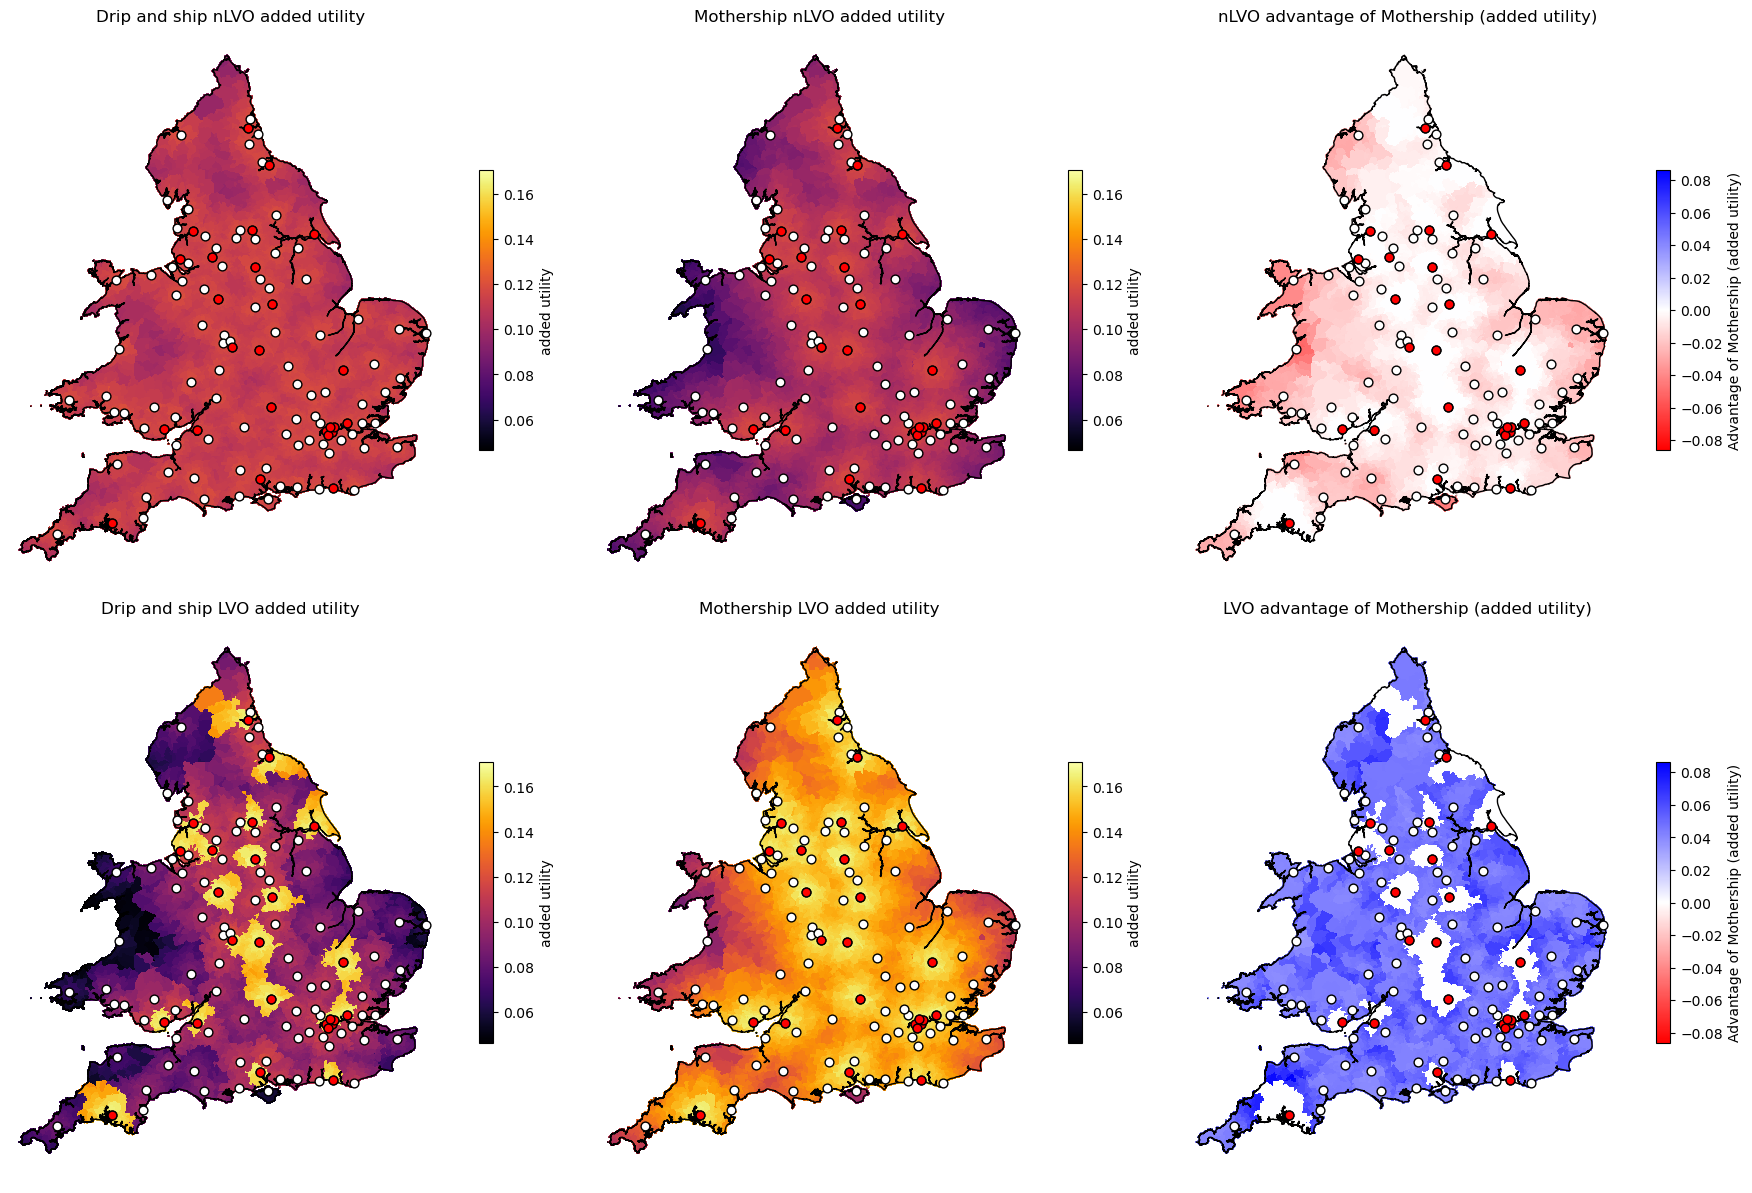

In [25]:
plot_six(
    'added_utility',
    'added utility',
    lsoa_data_gdf,
    hospitals_gdf,
    outline
)

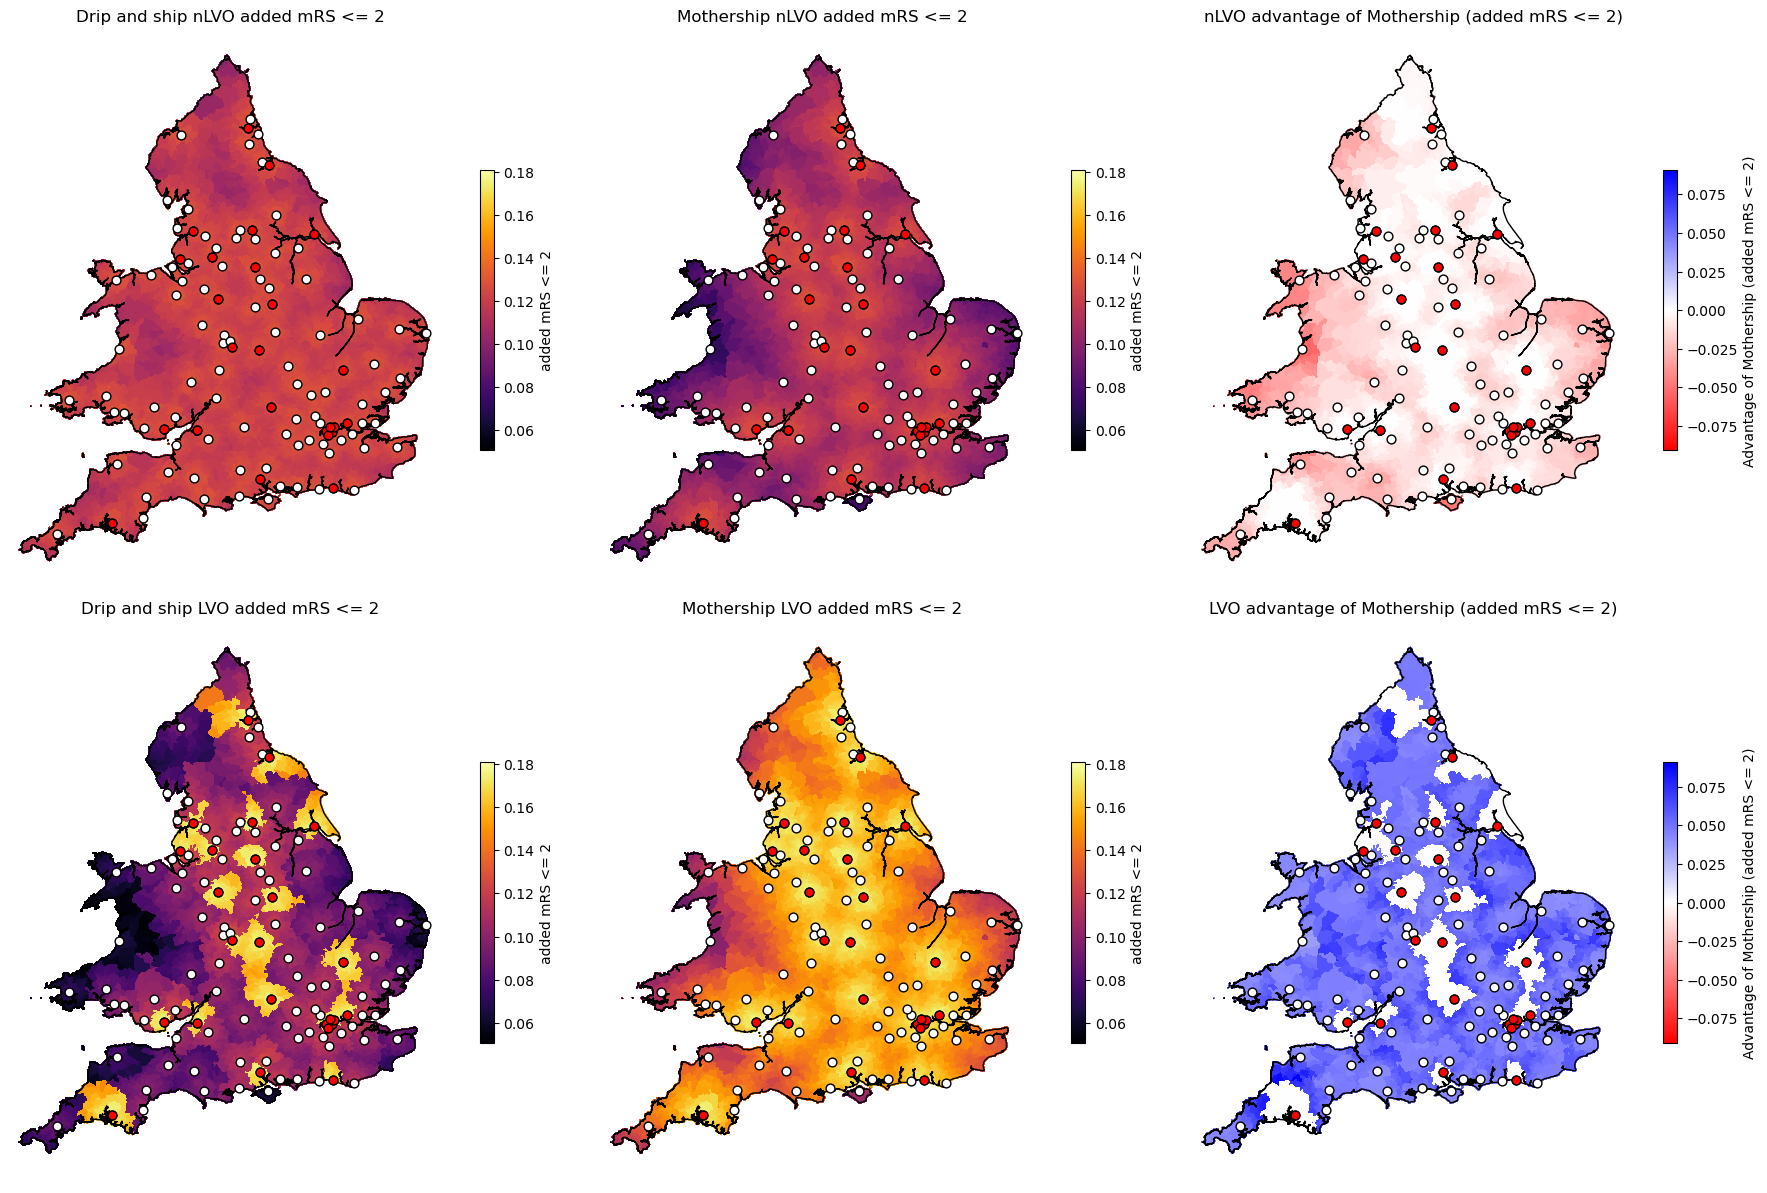

In [26]:
plot_six(
    'added_mrs_less_equal_2',
    'added mRS <= 2',
    lsoa_data_gdf,
    hospitals_gdf,
    outline
)

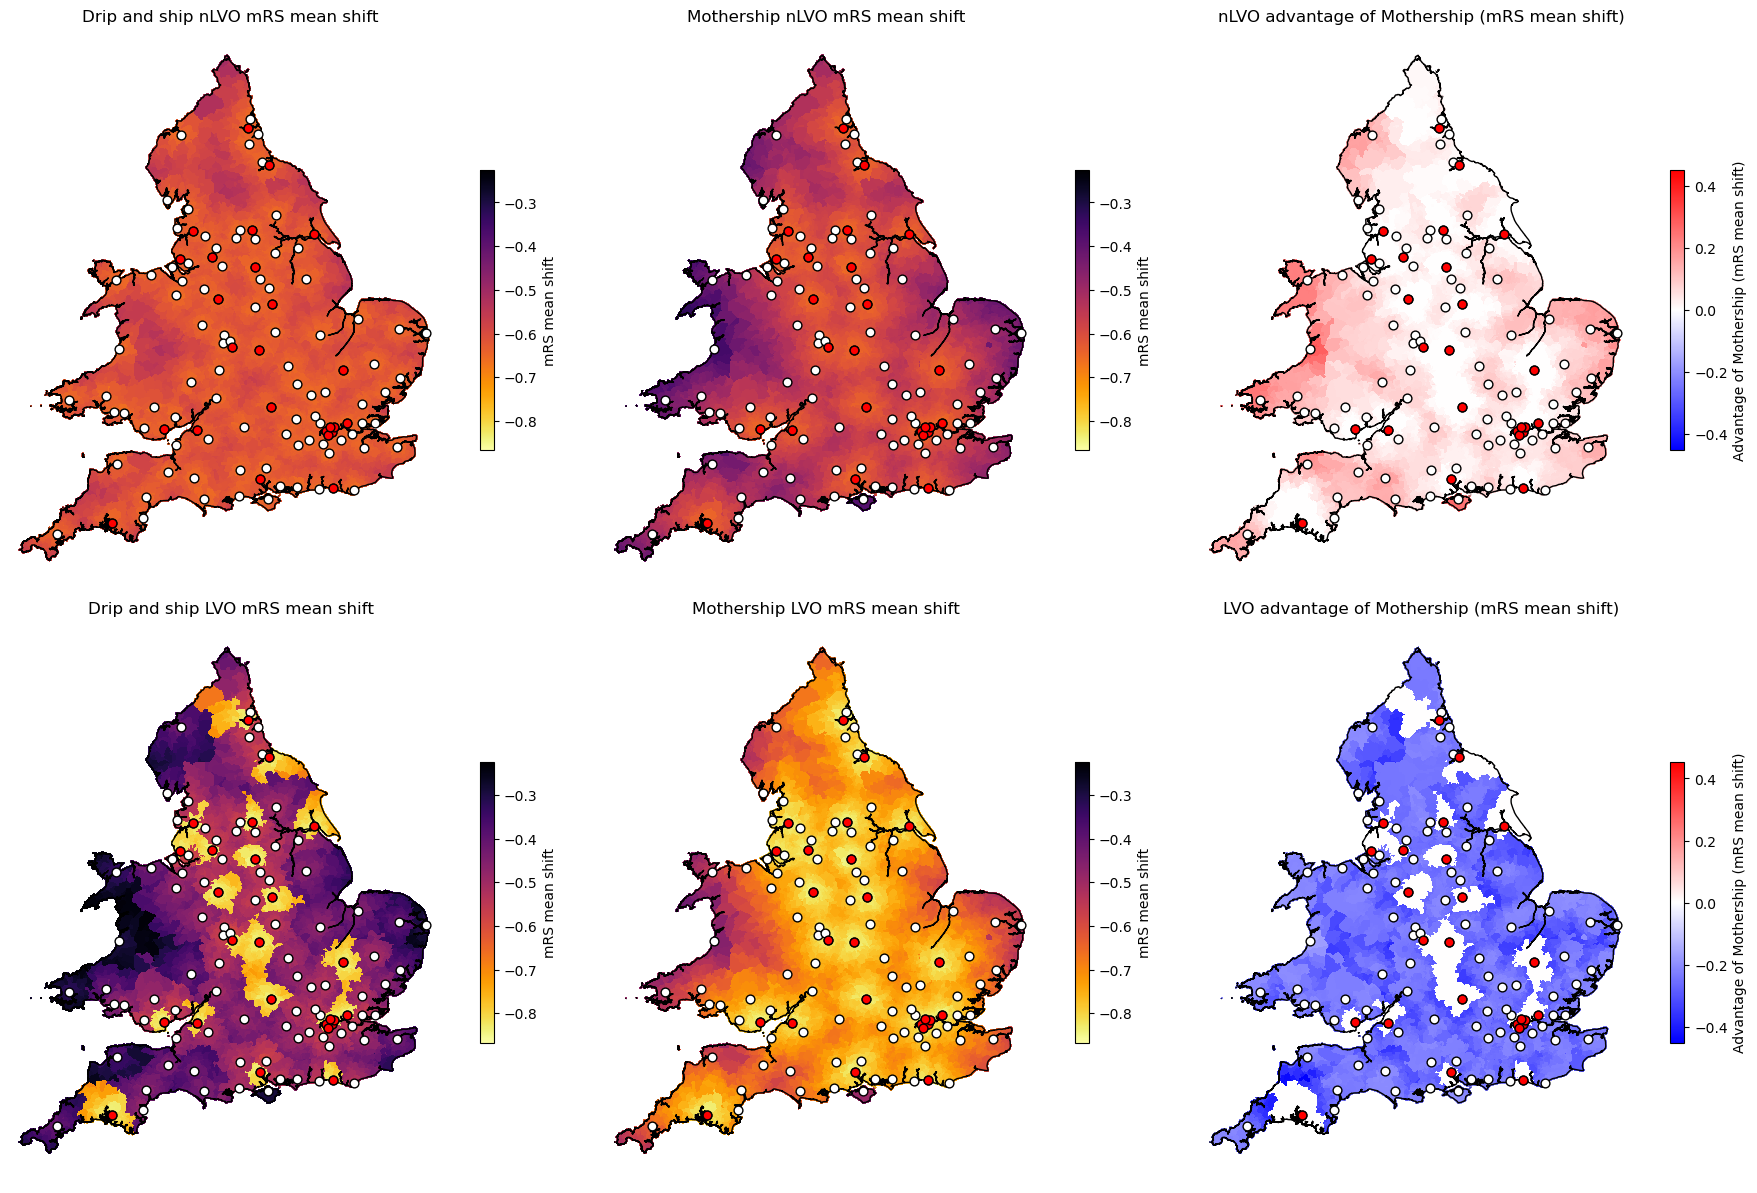

In [35]:
plot_six(
    'mrs_shift',
    'mRS mean shift',
    lsoa_data_gdf,
    hospitals_gdf,
    outline,
    reverse_cmaps=True
)

Plot weighted benefit

In [36]:
def plot_three(
        data_field,
        data_name,
        lsoa_data_gdf,
        hospitals_gdf,
        outline,
        reverse_cmaps=False
    ):
    # Check weighted data exists
    col = f'weighted_drip_ship_{data_field}'
    
    cmap = 'inferno'
    cmap_diff = 'bwr_r'
    if reverse_cmaps:
        cmap += '_r'
        cmap_diff += '_r'
        cmap = cmap.split('_r_r')[0]
        cmap_diff = cmap_diff.split('_r_r')[0]
    cmaps = [cmap, cmap, cmap_diff]
    
    if col not in lsoa_data_gdf.columns:
        print ('Required data does not exist')
    else:
        lsoa_data_gdf[f'weighted_mothership_advantage_{data_field}'] = (
            lsoa_data_gdf[f'weighted_mothership_{data_field}'] - 
            lsoa_data_gdf[f'weighted_drip_ship_{data_field}'])
    
        fig = plt.figure(figsize=(18,6))
    
        # Set up columns to map
        cols = [
            f'weighted_drip_ship_{data_field}', 
            f'weighted_mothership_{data_field}',
            f'weighted_mothership_advantage_{data_field}']
    
        titles = [
            f'Weighted drip and ship for {data_name}',
            f'Weighted mothership for {data_name}',
            f'Weighted advantage of mothership for {data_name}']
    
        # Find absolute maximum of data extent
        vmax = np.max([lsoa_data_gdf[col].max() for col in cols[0:2]])
        vmin = np.min([lsoa_data_gdf[col].min() for col in cols[0:2]])
    
        for i, col in enumerate(cols):
            ax = fig.add_subplot(1, 3, i+1)
    
            # Radjust vmin and max for advantage plot
            if i == 2:
                vmax = lsoa_data_gdf[col].max()
                vmin = lsoa_data_gdf[col].min()
                vmax = max(abs(vmax), abs(vmin))
                vmin = -vmax
    
            # Plot data
            lsoa_data_gdf.plot(ax=ax, # Set which axes to use for plot (only one here)
                        column=col, # Column to apply colour
                        antialiased=False, # Avoids artifact boundry lines
                        edgecolor='face', # Make LSOA boundry same colour as area
                        vmin=vmin, # Manual scale min (remove to make automatic)
                        vmax=vmax, # Manual scale max (remove to make automatic)
                        cmap=cmaps[i], # Colour map to use
                        # Adjust size of colourmap key, and add label
                        legend_kwds={'shrink':0.5, 'label':f'{data_name}'},
                        # Set to display legend
                        legend=True)
            
            # Add country boarder
            outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
            
            # Add hospitals
            mask = hospitals_gdf['use_ivt'] == 1
            hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
            mask = hospitals_gdf['use_mt'] == 1
            hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')
    
            # Tighten map around mainland England and Wales
            ax.set_xlim(120000)
    
            # Add title
            ax.set_title(titles[i])
            ax.set_axis_off() # Turn of axis line and numbers
        
        plt.tight_layout(pad=1)
        plt.savefig(f'./output/{data_field}_weighted_results.jpg', dpi=300, bbox_inches='tight')
        plt.show()

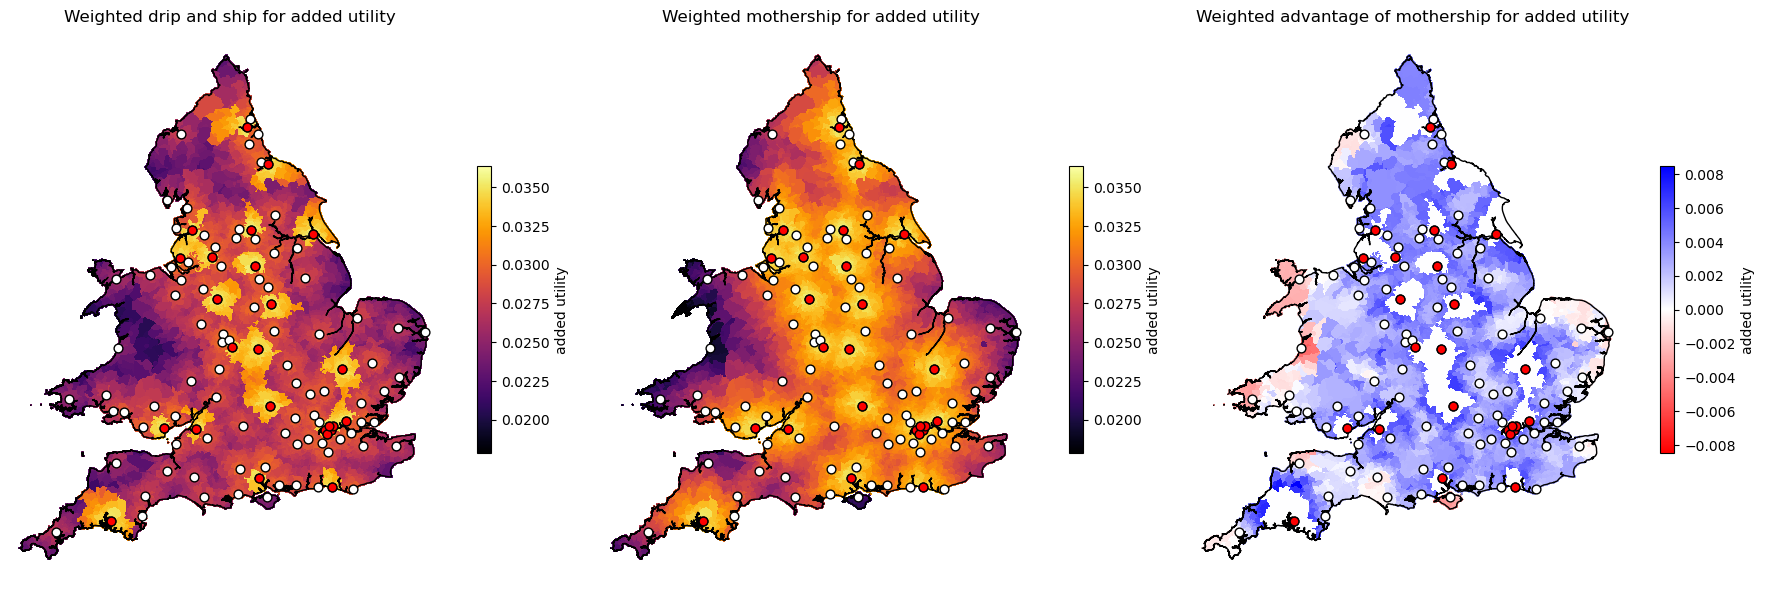

In [31]:
plot_three(
    'added_utility',
    'added utility',
    lsoa_data_gdf,
    hospitals_gdf,
    outline
)

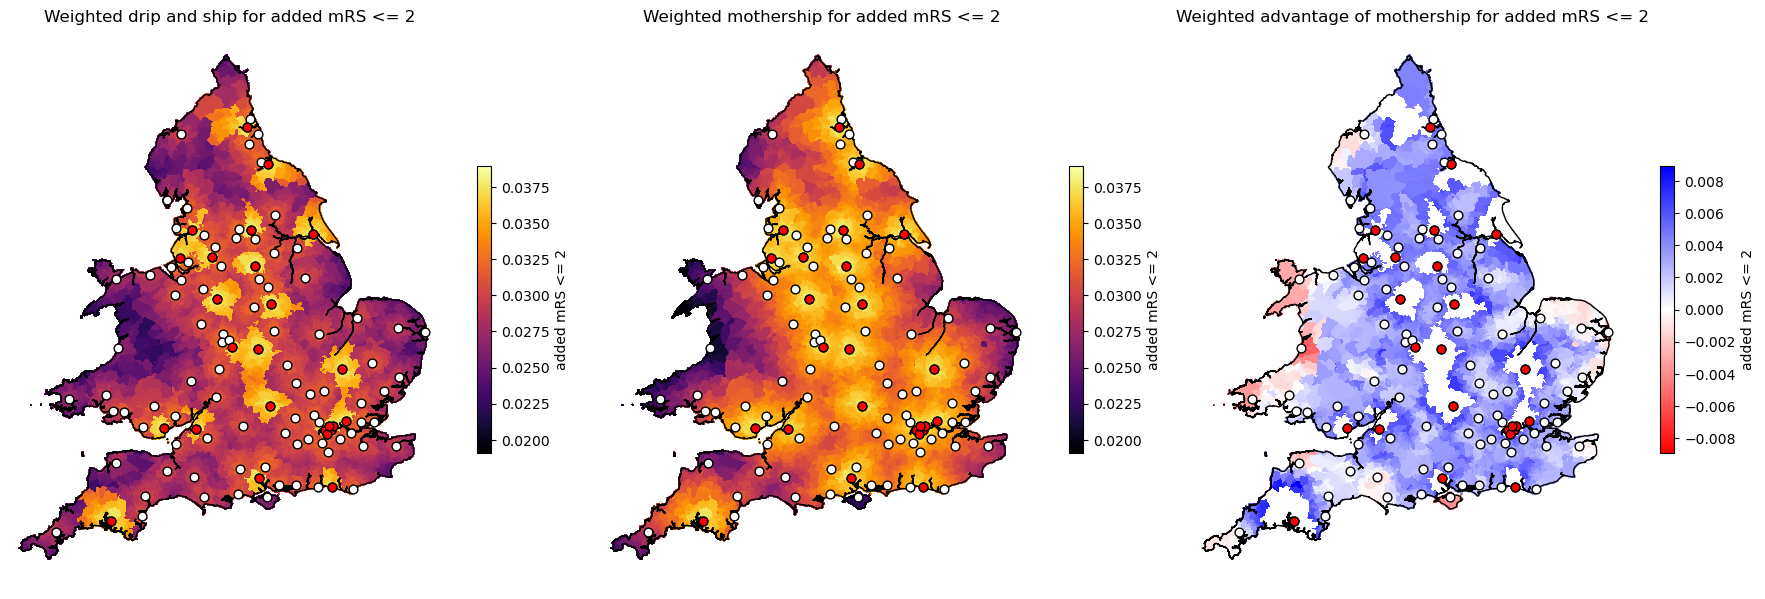

In [32]:
plot_three(
    'added_mrs_less_equal_2',
    'added mRS <= 2',
    lsoa_data_gdf,
    hospitals_gdf,
    outline
)

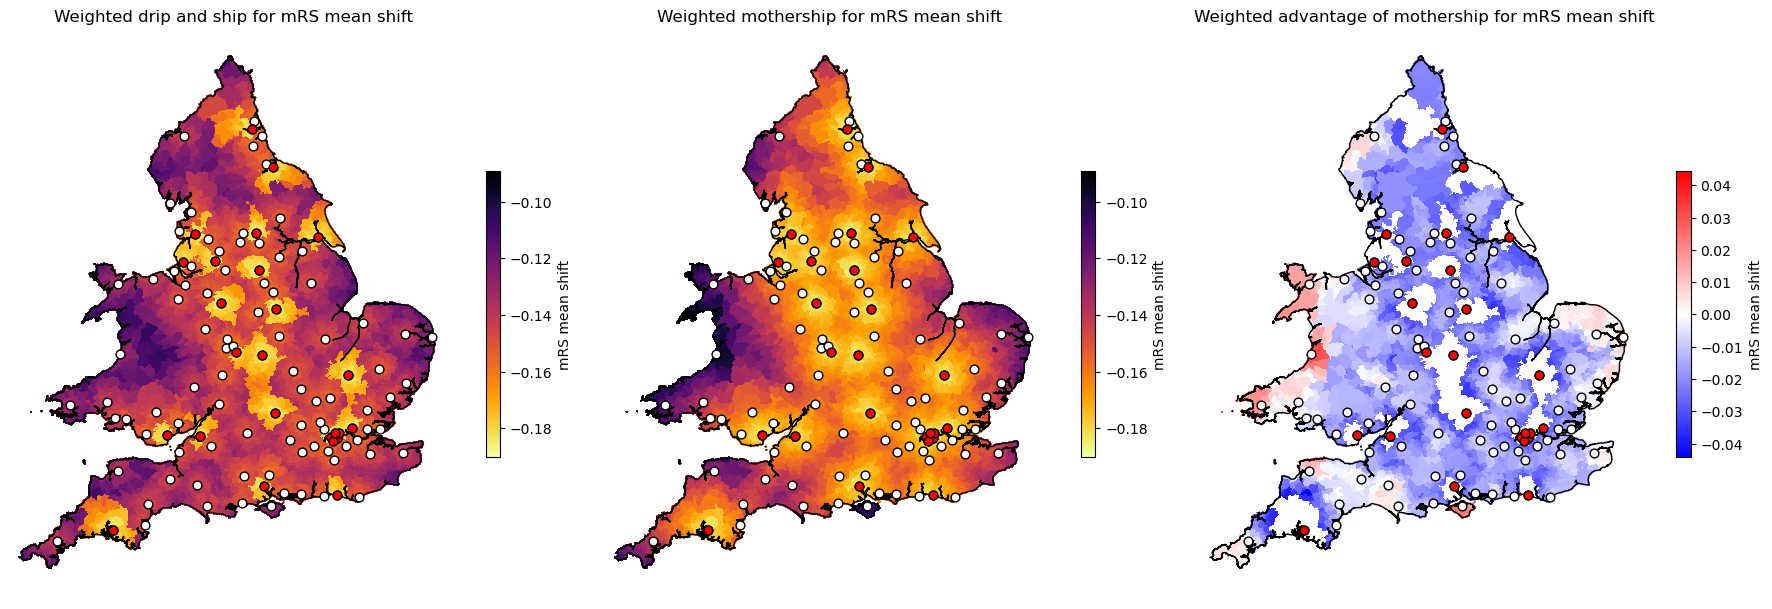

In [37]:
plot_three(
    'mrs_shift',
    'mRS mean shift',
    lsoa_data_gdf,
    hospitals_gdf,
    outline,
    reverse_cmaps=True
)